In [1]:
# Required Imports
import os, json, time
from pyproj import Transformer, Geod    
from wildfire.Reader import Reader as WFReader
import geojson
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_76903/3262185334.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)


SI_PER_YEAR_INPUT_PATH = output_paths.get('stage1_si_per_year_csv')



In [3]:
per_year_df = pd.read_csv(SI_PER_YEAR_INPUT_PATH)


In [4]:
# Display the column headers and basic information for the politician dataset
print("\nPer Year Smoke Imact + Acres Burned - Column Headers:")
print(per_year_df.columns)

print("\nPer Year Smoke Imact + Acres Burned - Basic Info:")
print(per_year_df.info())

print("\nPer Year Smoke Imact + Acres Burned - First 5 Rows:")
print(per_year_df.head())


Per Year Smoke Imact + Acres Burned - Column Headers:
Index(['fire_year', 'total_weighted_smoke_impact', 'total_acres_burned'], dtype='object')

Per Year Smoke Imact + Acres Burned - Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fire_year                    61 non-null     int64  
 1   total_weighted_smoke_impact  61 non-null     float64
 2   total_acres_burned           61 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.6 KB
None

Per Year Smoke Imact + Acres Burned - First 5 Rows:
   fire_year  total_weighted_smoke_impact  total_acres_burned
0       1961                     0.000000            0.000000
1       1962                     0.000000            0.000000
2       1963                     0.000000            0.000000
3       1964                     0.000256           28.4

fire year: 1860
fire year: 1860
fire year: 1860
fire year: 1870
fire year: 1870
fire year: 1878
fire year: 1878
fire year: 1880
fire year: 1880
fire year: 1880
fire year: 1880
fire year: 1880
fire year: 1880
fire year: 1881
fire year: 1885
fire year: 1886
fire year: 1888
fire year: 1888
fire year: 1888
fire year: 1888
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1889
fire year: 1890
fire year: 1890
fire year: 1890
fire year: 1890
fire year: 1890
fire year: 1890
fire year: 1890
fire year: 1890
fire year: 1890
fire year: 1890
fire year: 1890
fire year: 1891
fire year: 1891
fire year: 1891
fire year: 1892
fire year: 1893
fire year: 1893
fire year: 1893
fire year: 1893
fire year: 1894
fire year: 1895
fire year: 1895
fire year: 1896
fire year: 1896
fire year: 1898
fire year: 1898
fire year: 1898
fire year: 1898
fire year: 1899
fire year: 1901
fire yea

KeyboardInterrupt: 

In [ ]:
print(fire_distances)

## Not working properly

In [5]:
# Constants
CITY_LOCATIONS = {
    'memphis': {'city': 'Memphis', 'latlon': [35.11, -89.97]}
}
YEAR_RANGE = (1961, 2021)  # Year range for filtering
MAX_DISTANCE = 1800  # Maximum distance in miles

# Function to compute the shortest distance from a point to the fire perimeter
def shortest_distance_from_place_to_fire_perimeter(place=None, ring_data=None):
    geodcalc = Geod(ellps='WGS84')  # Use the WGS84 ellipsoid for geodetic calculations
    closest_point = []
    lat_city, lon_city = place  # Correctly access latitude and longitude
    
    # Debugging: Check the structure of ring_data
    if not isinstance(ring_data, list) or len(ring_data) == 0:
        print(f"Invalid ring_data format: {ring_data}")
        return closest_point  # Return empty if the structure is invalid

    for point in ring_data:
        if not isinstance(point, list) or len(point) < 2:
            print(f"Invalid point format: {point}")
            continue  # Skip invalid points
        
        # Calculate the distance in meters, and convert to miles
        d = geodcalc.inv(lon_city, lat_city, point[0], point[1])  # lon, lat for geodetic calculations
        distance_in_miles = d[2] * 0.00062137  # Convert from meters to miles
        if not closest_point or distance_in_miles < closest_point[0]:
            closest_point = [distance_in_miles, point]
    return closest_point

In [6]:
# Load the wildfire data using the wildfire reader
EXTRACT_FILENAME = "raw/USGS_Wildland_Fire_Combined_Dataset.json"
wfreader = WFReader(EXTRACT_FILENAME)

# Load all features
feature_list = []
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature = wfreader.next()

# Get city location (Memphis)
place = CITY_LOCATIONS["memphis"]['latlon']  # Extract latlon from the city location

# Create a list to store distances
fire_distances = []

# Loop through all fire features and calculate distances
for wf_feature in feature_list:
    # Get the fire year
    wf_year = wf_feature['attributes'].get('Fire_Year')

    # Filter for the year range (1961 to 2021)
    if wf_year is None or not (YEAR_RANGE[0] <= wf_year <= YEAR_RANGE[1]):
        continue

    # Get the geometry (rings or curveRings)
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        print(f"Missing geometry in fire data: {wf_feature}")  # Debugging for missing geometry
        continue  # Skip if no geometry available

    # Compute the shortest distance to the fire perimeter
    distance = shortest_distance_from_place_to_fire_perimeter(place, ring_data)
    
    # Filter for distance within 1800 miles
    if distance and distance[0] <= MAX_DISTANCE:
        fire_distances.append(distance[0])  # Add the distance in miles

Invalid point format: {'b': [[-1934810.4616, -113974.30440000072], [-1934810.232777732, -113974.94540095767], [-1934810.3467498617, -113974.62480163362]]}
Invalid point format: {'b': [[-1934811.9395000003, -113970.38959999941], [-1934811.9341237186, -113970.4031921531], [-1934811.9367903844, -113970.3963921518]]}
Invalid point format: {'b': [[-1934816.5779, -113962.01899999939], [-1934816.5737907088, -113962.02445898463], [-1934816.575824042, -113962.0217256511]]}
Invalid point format: {'b': [[-1934832.2389000002, -113952.2968000006], [-1934832.0096319139, -113952.39511077626], [-1934832.124134086, -113952.34577780773]]}
Invalid point format: {'b': [[-1934837.8454, -113950.21829999983], [-1934837.826090547, -113950.22462419991], [-1934837.8357238816, -113950.22145753336]]}
Invalid point format: {'b': [[-1934877.4167, -113952.10139999911], [-1934874.699454591, -113951.41814289663], [-1934876.0585335395, -113951.77086978576]]}
Invalid point format: {'b': [[-1934882.7588, -113953.25159999

In [9]:
print(fire_distances)

[1017.7644408244478, 274.6935543579121, 1590.425098040593, 1375.3203212554968]


# Temporary

Distance Summary Statistics:
count       4.000000
mean     1064.550854
std       577.114923
min       274.693554
25%       831.996719
50%      1196.542381
75%      1429.096515
max      1590.425098
Name: distance_miles, dtype: float64


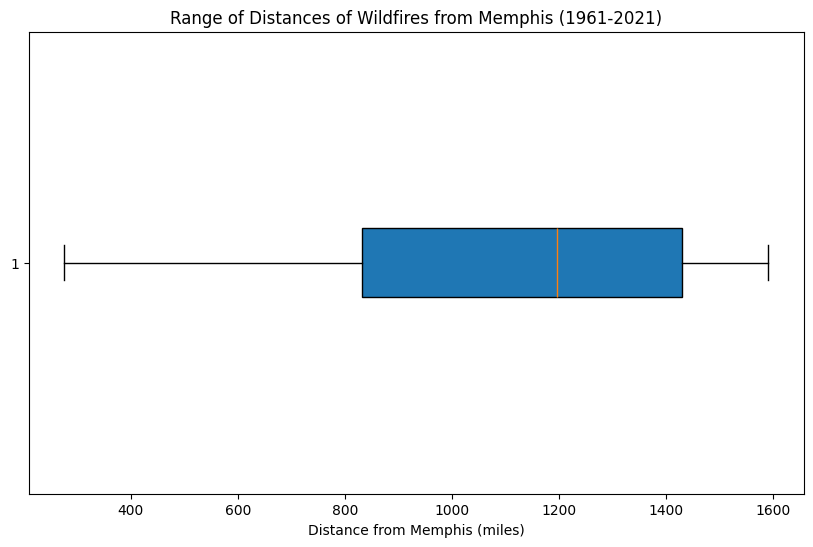


Average Distance: 1064.55 miles
Minimum Distance: 274.69 miles
Maximum Distance: 1590.43 miles


In [8]:
# Convert fire_distances to a DataFrame for easier analysis and plotting
distances_df = pd.DataFrame(fire_distances, columns=['distance_miles'])

# Calculate summary statistics
distance_summary = distances_df['distance_miles'].describe()
print("Distance Summary Statistics:")
print(distance_summary)

# Plot the range of values for fire distances
plt.figure(figsize=(10, 6))
plt.boxplot(distances_df['distance_miles'], vert=False, patch_artist=True)
plt.xlabel('Distance from Memphis (miles)')
plt.title('Range of Distances of Wildfires from Memphis (1961-2021)')
plt.show()

# Additional summary statistics
avg_distance = distances_df['distance_miles'].mean()
min_distance = distances_df['distance_miles'].min()
max_distance = distances_df['distance_miles'].max()

print(f"\nAverage Distance: {avg_distance:.2f} miles")
print(f"Minimum Distance: {min_distance:.2f} miles")
print(f"Maximum Distance: {max_distance:.2f} miles")

### Create the Plot

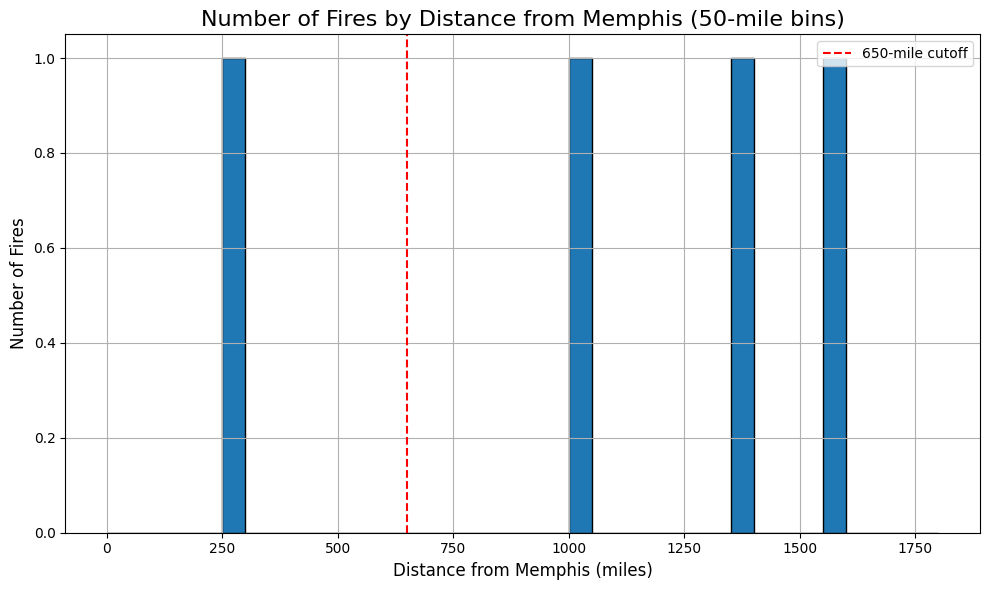

In [7]:

# Create bins of 50-mile intervals up to 1800 miles
distance_bins = list(range(0, MAX_DISTANCE + 1, 50))  # Bins from 0 to 1800 miles with a step of 50

# Create the histogram of fire counts by distance
plt.figure(figsize=(10, 6))
plt.hist(fire_distances, bins=distance_bins, edgecolor='black')

# Highlight the 650-mile cutoff for modeling
plt.axvline(x=650, color='r', linestyle='--', label='650-mile cutoff')

# Add titles and labels
plt.title('Number of Fires by Distance from Memphis (50-mile bins)', fontsize=16)
plt.xlabel('Distance from Memphis (miles)', fontsize=12)
plt.ylabel('Number of Fires', fontsize=12)

# Add legend
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

## Question 2

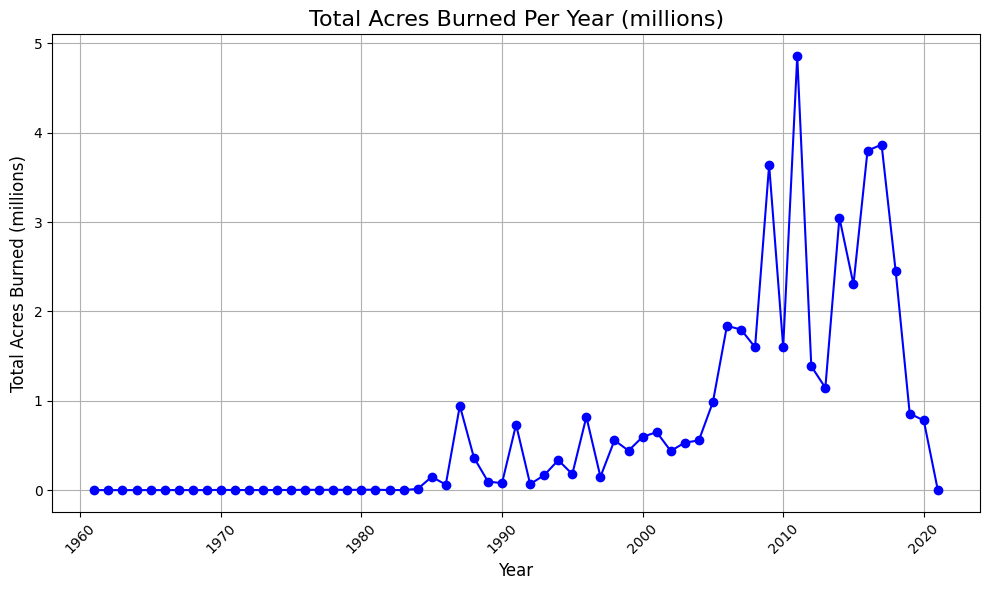

In [20]:
# %%
import matplotlib.pyplot as plt
import pandas as pd
import json

# %%
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

PER_YEAR_INPUT_PATH = output_paths.get('smoke_impacts_per_year_csv')

# %%
per_year_df = pd.read_csv(PER_YEAR_INPUT_PATH)

# Convert total acres burned to millions
per_year_df['total_acres_burned_millions'] = per_year_df['total_acres_burned'] / 1e6

# %%
# Plotting the time series of total acres burned per year in millions
plt.figure(figsize=(10, 6))

# Plot total acres burned (in millions) against the year
plt.plot(per_year_df['year'], per_year_df['total_acres_burned_millions'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Total Acres Burned Per Year (millions)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Acres Burned (millions)', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 3